# Introduction

The libraries below are required to run this notebook. They should automatically be installed with the supplied Conda environment.

In [1]:
import numpy as np
from scipy import stats

import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import pymc3 as pm
import pymc3.distributions.transforms as pmt
import arviz as az

A great tutorial to start with is given here: https://docs.pymc.io/notebooks/getting_started.html

However, we will start even more simpler: with a univariate normal distribution!

## Univariate Normal

### Generation and MLE

In [2]:
rng = np.random.default_rng(42)

mu, sigma = 3, 0.5
T = 20

coords = {'observation': range(T)}
x = rng.normal(mu, sigma, T)

In [3]:
# Maximum Likelihood Estimation
mu_mle, sd_mle = stats.norm.fit(x)

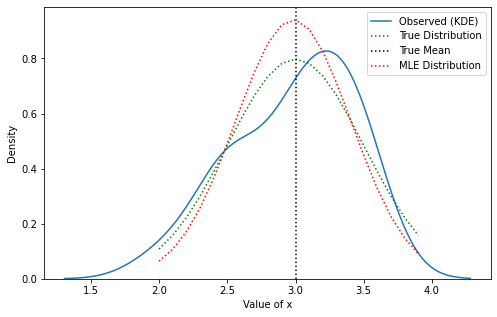

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(x, ax=ax, label='Observed (KDE)')
ax.set_xlabel("Value of x")

pts = np.arange(mu-2*sigma, mu+2*sigma, step=0.1)
theory = stats.norm.pdf(pts, loc=mu, scale=sigma)
ax.plot(pts, theory, color='green', linestyle=':', label='True Distribution')
ax.axvline(mu, color='black', linestyle=':', label='True Mean')

mle = stats.norm.pdf(pts, loc=mu_mle, scale=sd_mle)
ax.plot(pts, mle, color='red', linestyle=':', label='MLE Distribution')
# ax.axvline(mu_mle, color='red', linestyle=':', label='MLE Mean')
ax.legend()
fig;

### PyMC3 Model

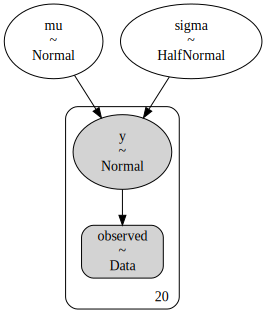

In [5]:
with pm.Model(coords=coords) as m:
    pm.Data("observed", x, dims=['observation'])
    
    pm.Normal('mu', mu=0, sd=10)
    pm.HalfNormal('sigma', sd=2)
    
    pm.Normal('y', mu=m['mu'], sd=m['sigma'], observed=m['observed'], dims=['observation'])
    
pm.model_to_graphviz(m)

In [6]:
with m:
    priors = pm.sample_prior_predictive()
    trace = pm.sample(draws=2000, tune=500, chains=2, cores=1, return_inferencedata=False)
    post_pred = pm.sample_posterior_predictive(trace)
    
    infd = az.from_pymc3(trace=trace, prior=priors, posterior_predictive=post_pred, coords=m.coords)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2 seconds.


0, dim: observation, 20 =? 20


0, dim: observation, 20 =? 20


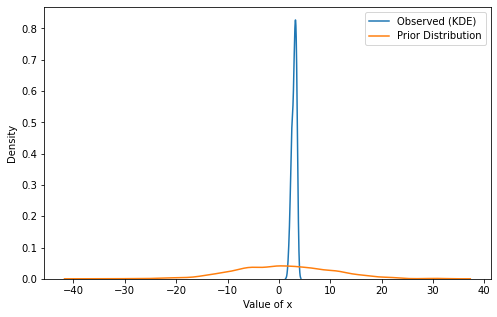

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(x, ax=ax, label='Observed (KDE)')
sns.kdeplot(infd.prior_predictive['y'].values.ravel(), ax=ax, label='Prior Distribution')

ax.set_xlabel("Value of x")
ax.legend()
fig;

### Posterior Predictions

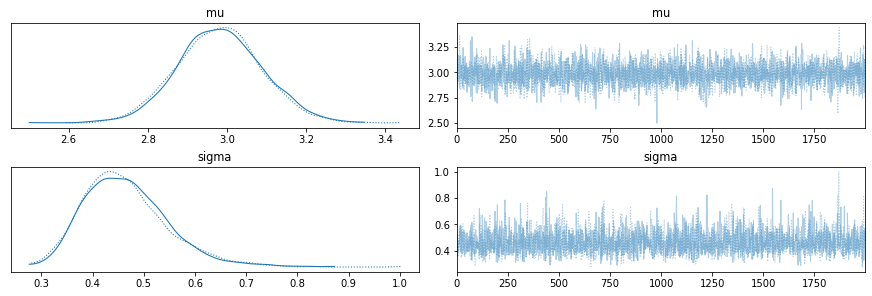

In [8]:
az.plot_trace(infd.posterior);

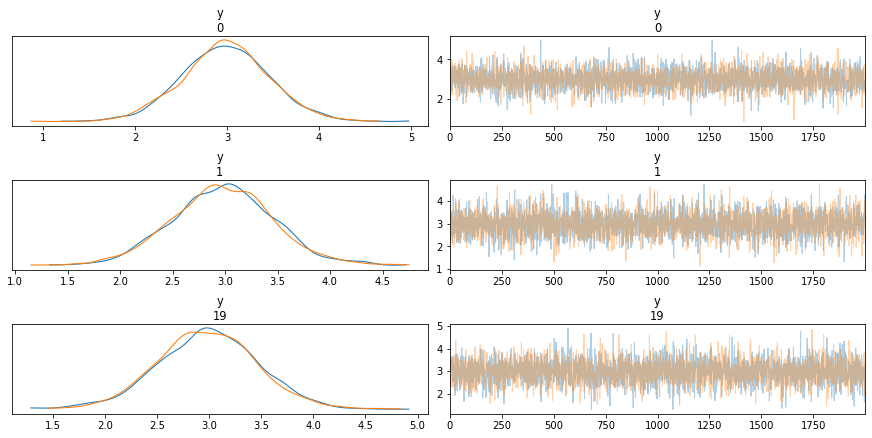

In [9]:
az.plot_trace(infd.posterior_predictive.sel(observation=[0, 1, T-1]), compact=False);

### Results

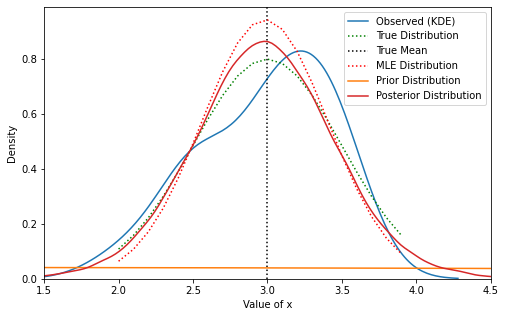

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(x, ax=ax, label='Observed (KDE)')

pts = np.arange(mu-2*sigma, mu+2*sigma, step=0.1)
theory = stats.norm.pdf(pts, loc=mu, scale=sigma)
ax.plot(pts, theory, color='green', linestyle=':', label='True Distribution')
ax.axvline(mu, color='black', linestyle=':', label='True Mean')

mle = stats.norm.pdf(pts, loc=mu_mle, scale=sd_mle)
ax.plot(pts, mle, color='red', linestyle=':', label='MLE Distribution')

sns.kdeplot(infd.prior_predictive['y'].values.ravel(), ax=ax, color='C1', label='Prior Distribution')
sns.kdeplot(infd.posterior_predictive['y'].values.ravel(), ax=ax, color='C3', label='Posterior Distribution')

ax.set_xlabel("Value of x")
ax.set_xlim(mu-3*sigma, mu+3*sigma)
ax.legend()
fig;

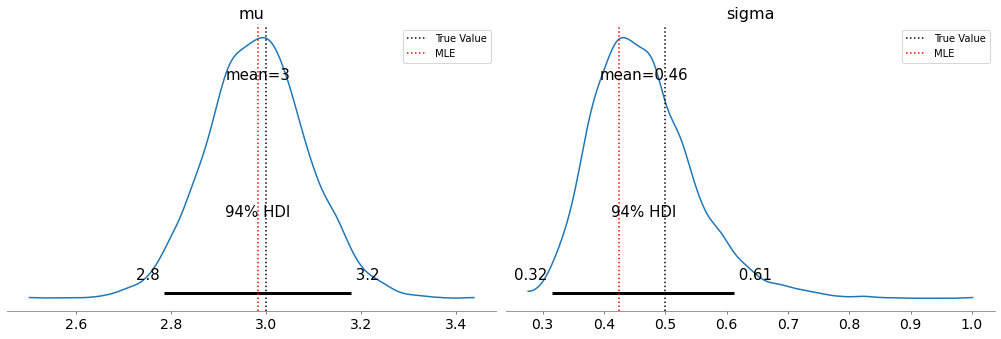

In [11]:
axes = az.plot_posterior(infd)
axes[0].axvline(mu, color='black', linestyle=':', label='True Value')
axes[0].axvline(mu_mle, color='red', linestyle=':', label='MLE')
axes[0].legend()
axes[1].axvline(sigma, color='black', linestyle=':', label='True Value')
axes[1].axvline(sd_mle, color='red', linestyle=':', label='MLE')
axes[1].legend()
axes;